<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Updated_German_experiment_15_01_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 24.1 MB/s eta 0:00:00

LOADING AND PREPROCESSING GERMAN CREDIT DATASET
Dataset shape: (1000, 21)
Target distribution: {0: 700, 1: 300}
Default rate: 30.00%
Imbalance ratio: 2.33:1

Categorical columns (13): ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numeric columns (7): ['duration', 'credit_a

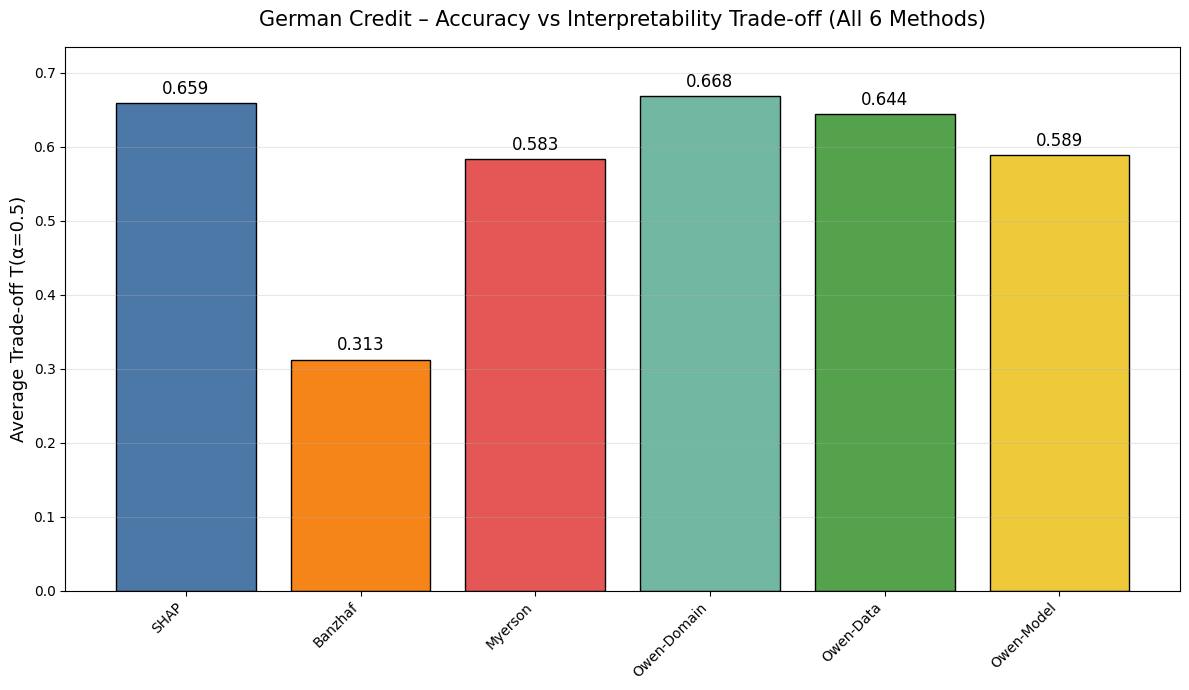

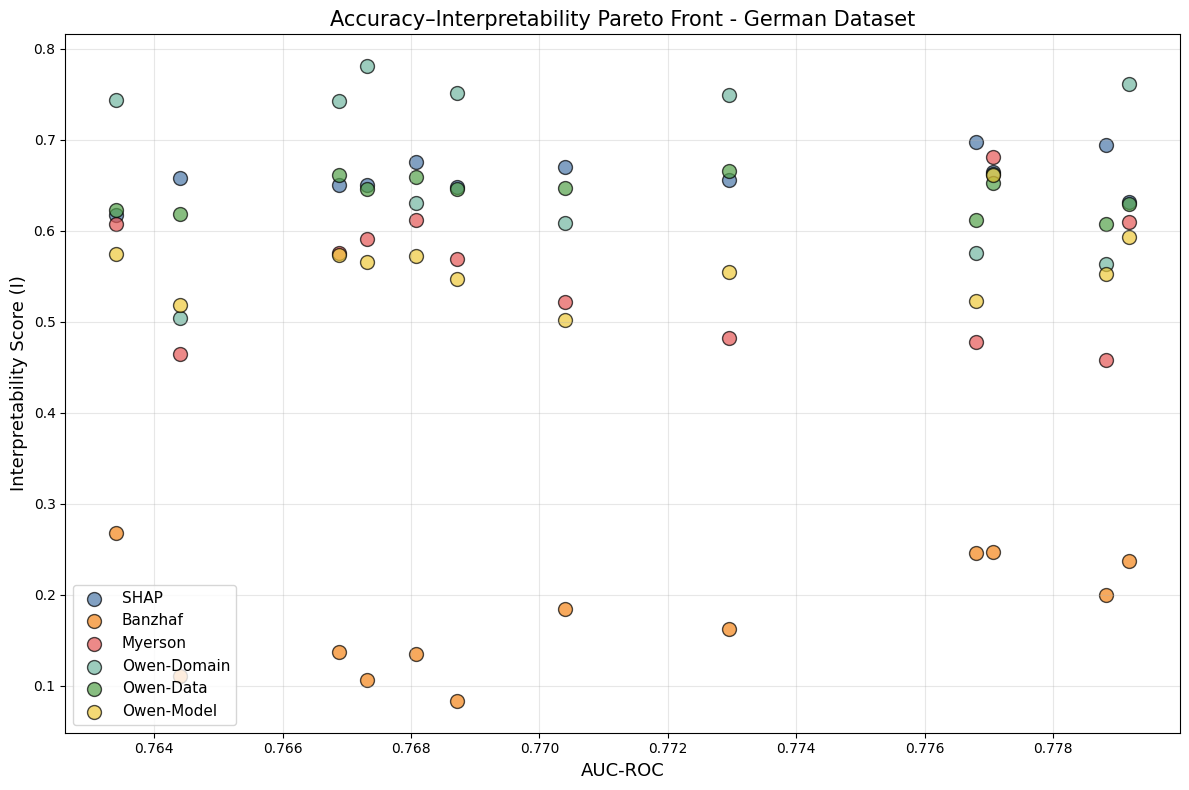

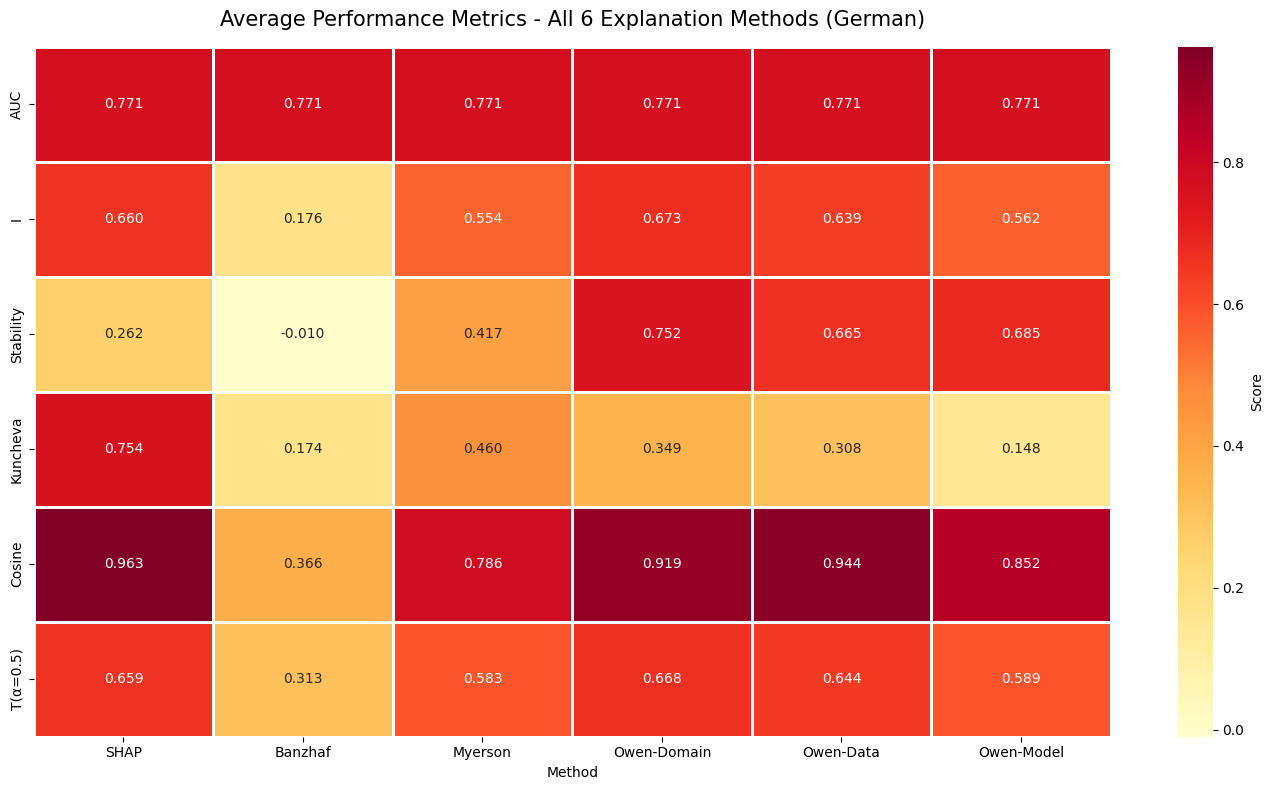


STATISTICAL ANALYSIS - ALL 6 METHODS

Friedman Test for T(α=0.5):
Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 45.8571, p = 0.000000
✓ SIGNIFICANT differences between methods

Nemenyi Post-Hoc Test (p-values):
        0       1       2       3       4       5
0  1.0000  0.0000  0.0379  0.9995  0.9530  0.0064
1  0.0000  1.0000  0.1212  0.0000  0.0001  0.3632
2  0.0379  0.1212  1.0000  0.0927  0.3014  0.9943
3  0.9995  0.0000  0.0927  1.0000  0.9943  0.0194
4  0.9530  0.0001  0.3014  0.9943  1.0000  0.0927
5  0.0064  0.3632  0.9943  0.0194  0.0927  1.0000

Pairwise Wilcoxon Tests for T(α=0.5):
SHAP vs Banzhaf: p=0.0005 (means: 0.659 vs 0.313) ✓
SHAP vs Myerson: p=0.0015 (means: 0.659 vs 0.583) ✓
SHAP vs Owen-Domain: p=0.7910 (means: 0.659 vs 0.668) ✗
SHAP vs Owen-Data: p=0.0640 (means: 0.659 vs 0.644) ✗
SHAP vs Owen-Model: p=0.0005 (means: 0.659 vs 0.589) ✓
Owen-Domain vs Owen-Data: p=0.2334 (means: 0.668 vs 0.644) ✗
Owen-Domai

In [1]:
# ============================================================
# GERMAN CREDIT DATASET - UNIFIED GAME THEORY EXPLAINABILITY
# ============================================================

# Install missing libraries if needed
!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS GERMAN CREDIT DATASET
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING GERMAN CREDIT DATASET")
print("="*80)

# Load German Credit dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = ['checking_status','duration','credit_history','purpose','credit_amount',
        'savings_status','employment','installment_commitment','personal_status',
        'other_parties','residence_since','property_magnitude','age',
        'other_payment_plans','housing','existing_credits','job',
        'num_dependents','own_telephone','foreign_worker','target']

df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['target'] = df['target'].map({1:0, 2:1})  # 1=good(0), 2=bad(1)

X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64']).columns.tolist()

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                         sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
print(f"\nNumber of processed features: {d}")

# Get feature names
fnames = preprocessor.get_feature_names_out()
print(f"\nFirst 10 feature names: {fnames[:10]}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                            eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                             verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (ALL 6 METHODS)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values for a trained pipeline"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]  # For binary classification
        elif sv.ndim == 3:
            return sv[:, :, 1]  # For multi-class
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using fallback...")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_test), n_features))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def build_feature_graph(preprocessor, X, threshold=0.25):
    """Build feature graph for Myerson"""
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)
    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))

    for i in range(d):
        for j in range(i+1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])
    return G, corr

def compute_myerson(pipe, X_test, G, alpha=0.5):
    """Compute Myerson values using feature graph"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d = len(shap_mean)
    phi = np.zeros(d)

    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(50, len(X_test)), 1))

# Owen grouping strategies for German dataset
def build_domain_groups_german(fnames):
    """Build domain-specific groups for German dataset"""
    groups = {
        "CreditHistory": [],
        "FinancialStatus": [],
        "PersonalInfo": [],
        "LoanDetails": [],
        "Employment": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Credit history related
        if "checking_status" in lname or "savings_status" in lname or "credit_history" in lname:
            groups["CreditHistory"].append(i)

        # Financial status
        elif "credit_amount" in lname or "property_magnitude" in lname or "housing" in lname:
            groups["FinancialStatus"].append(i)

        # Personal info
        elif "age" in lname or "personal_status" in lname or "num_dependents" in lname or "residence_since" in lname:
            groups["PersonalInfo"].append(i)

        # Loan details
        elif "duration" in lname or "purpose" in lname or "installment_commitment" in lname:
            groups["LoanDetails"].append(i)

        # Employment
        elif "employment" in lname or "job" in lname:
            groups["Employment"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups using SHAP correlation"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Redistribute SHAP values using Owen grouping"""
    d = len(phi)
    out = np.zeros(d)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue

        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)

        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per

    return out

def compute_Q(groups, dep):
    """Compute group quality metric Q"""
    try:
        d = dep.shape[0]
        group_id = np.full(d, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d):
            for j in range(i+1, d):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan

# ============================================================
# 4. METRICS
# ============================================================
def stability_cv(expl_list):
    """Compute coefficient of variation stability metric"""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine directional consistency"""
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p+1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos = 1 - cosine(v_p, v_s)
            cos_sims.append(cos)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (ALL 6 METHODS)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
X_proc = preprocessor.transform(X)
corr = np.corrcoef(X_proc.T)
G_myerson = nx.Graph()
d_graph = corr.shape[0]
G_myerson.add_nodes_from(range(d_graph))
for i in range(d_graph):
    for j in range(i+1, d_graph):
        if abs(corr[i, j]) >= 0.25:
            G_myerson.add_edge(i, j, weight=corr[i, j])
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation - Using 5 folds for more stable estimates with n=1000
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        # Lists to store explanations for each fold
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_dom_runs, owen_data_runs, owen_model_runs = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Train model once per fold
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Compute AUC (only once per fold)
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Sample instances for explanations
            X_sample = X_te.sample(n=min(30, len(X_te)), random_state=42)  # Reduced for smaller dataset

            # Get feature names
            fnames = preprocessor.get_feature_names_out()

            # 1. SHAP values
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((len(X_sample), n_features)))
                shap_vals = None

            # 2. Banzhaf values
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)  # Reduced for speed
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(3, len(X_sample)), n_features)))

            # 3. Myerson values
            try:
                if shap_vals is not None:
                    myerson_vals = compute_myerson(pipe, X_sample, G_myerson)
                else:
                    myerson_vals = np.zeros((min(30, len(X_sample)), d))
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(30, len(X_sample)), n_features)))

            # 4. Owen-Domain values (using domain groups)
            try:
                dom_groups = build_domain_groups_german(fnames)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_dom = np.tile(owen_from_shap(phi, dom_groups), (len(X_sample), 1))
                else:
                    owen_dom = np.zeros((len(X_sample), d))
                owen_dom_runs.append(owen_dom)

                # Compute Q for domain groups
                X_tr_proc = preprocessor.transform(X_tr)
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_runs.append(np.zeros((len(X_sample), d)))
                Q_dom_list.append(np.nan)

            # 5. Owen-Data values (using data-driven groups)
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)  # Reduced clusters
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_data = np.tile(owen_from_shap(phi, data_groups), (len(X_sample), 1))
                else:
                    owen_data = np.zeros((len(X_sample), d))
                owen_data_runs.append(owen_data)
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_runs.append(np.zeros((len(X_sample), d)))
                Q_data_list.append(np.nan)

            # 6. Owen-Model values (using model-driven groups)
            try:
                if shap_vals is not None:
                    bg_sample = X_tr.sample(n=min(50, len(X_tr)), random_state=42)  # Reduced background
                    shap_bg = get_shap_reliable(pipe, bg_sample)
                    model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                    phi = np.mean(shap_vals, axis=0)
                    owen_model = np.tile(owen_from_shap(phi, model_groups), (len(X_sample), 1))
                else:
                    owen_model = np.zeros((len(X_sample), d))
                    model_groups, dep_mod = {"Model_Default": list(range(d))}, np.eye(d)
                owen_model_runs.append(owen_model)
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_runs.append(np.zeros((len(X_sample), d)))
                Q_model_list.append(np.nan)

        # Compute mean AUC for this model-sampler combination
        auc_mean = np.mean(aucs)

        # Compute metrics for each explanation method
        explanation_methods = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen-Domain', owen_dom_runs),
            ('Owen-Data', owen_data_runs),
            ('Owen-Model', owen_model_runs)
        ]

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Dataset': 'German',
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - ALL 6 EXPLANATION METHODS")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('german_unified_results_fixed.csv', index=False)
    print("\n✓ Results saved to: german_unified_results_fixed.csv")

# ============================================================
# 7. VISUALIZATIONS
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    colors = {
        'SHAP': '#4C78A8',
        'Banzhaf': '#F58518',
        'Myerson': '#E45756',
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    # 1. Average Trade-off by Method
    plt.figure(figsize=(12, 7))
    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("German Credit – Accuracy vs Interpretability Trade-off (All 6 Methods)",
              fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('german_all_methods_tradeoff.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(12, 8))
    for method in method_order:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['AUC'], sub['I'], s=100, label=method,
                       color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - German Dataset", fontsize=15)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('german_all_methods_pareto.png', dpi=300)
    plt.show()

    # 3. Heatmap of average metrics
    plt.figure(figsize=(14, 8))
    heatmap_data = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'I': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'T(α=0.5)': 'mean'
    }).reindex(method_order).T

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
    plt.title("Average Performance Metrics - All 6 Explanation Methods (German)", fontsize=15, pad=15)
    plt.tight_layout()
    plt.savefig('german_all_methods_heatmap.png', dpi=300)
    plt.show()

# ============================================================
# 8. STATISTICAL ANALYSIS
# ============================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - ALL 6 METHODS")
print("="*80)

from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp

# Friedman test for T(α=0.5)
print("\nFriedman Test for T(α=0.5):")
pivoted = metrics.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method',
    aggfunc='mean'
)

# Keep only methods with complete data for all configurations
complete_methods = pivoted.dropna(axis=1, how='any').columns.tolist()
complete_methods = [m for m in method_order if m in complete_methods]

if len(complete_methods) >= 3:
    data_matrix = pivoted[complete_methods].values

    # Friedman test
    stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])
    print(f"Methods compared: {complete_methods}")
    print(f"Friedman χ² = {stat:.4f}, p = {p_value:.6f}")

    if p_value < 0.05:
        print("✓ SIGNIFICANT differences between methods")

        # Post-hoc Nemenyi
        nemenyi_results = sp.posthoc_nemenyi_friedman(data_matrix)
        print("\nNemenyi Post-Hoc Test (p-values):")
        print(nemenyi_results.round(4))
    else:
        print("✗ No significant differences")
else:
    print("Insufficient complete data for Friedman test")

# Pairwise Wilcoxon tests for key comparisons
print("\nPairwise Wilcoxon Tests for T(α=0.5):")
key_pairs = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen-Domain'),
    ('SHAP', 'Owen-Data'),
    ('SHAP', 'Owen-Model'),
    ('Owen-Domain', 'Owen-Data'),
    ('Owen-Domain', 'Owen-Model')
]

for method1, method2 in key_pairs:
    if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
        data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
        data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

        if len(data1) > 1 and len(data2) > 1:
            try:
                stat, p_value = wilcoxon(data1, data2) if len(data1) == len(data2) else (np.nan, np.nan)
                mean1, mean2 = np.mean(data1), np.mean(data2)
                sig = "✓" if p_value < 0.05 else "✗"
                print(f"{method1} vs {method2}: p={p_value:.4f} (means: {mean1:.3f} vs {mean2:.3f}) {sig}")
            except:
                print(f"{method1} vs {method2}: Could not compute")

print("\n" + "="*80)
print("UNIFIED EXPERIMENT COMPLETE!")
print("="*80)
print("\nSummary:")
print(f"- Total configurations: {len(models) * len(resamplers)}")
print(f"- Total method comparisons: {len(all_records)}")
print(f"- All 6 methods: SHAP, Banzhaf, Myerson, Owen-Domain, Owen-Data, Owen-Model")
print(f"- Each model-sampler trained only once per fold")
print(f"- Consistent AUC values across all explanation methods")


COMPREHENSIVE STATISTICAL ANALYSIS - GERMAN DATASET
✓ Unified results loaded successfully
Shape: (72, 12), Methods: 6
Methods present: ['SHAP' 'Banzhaf' 'Myerson' 'Owen-Domain' 'Owen-Data' 'Owen-Model']

1. LEVENE'S TEST (Equal Variances)

AUC:
  W = 0.0000, p = 1.0000 → Equal variances ✓
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

I:
  W = 7.9967, p = 0.0000 → Unequal variances ✗
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

T(α=0.5):
  W = 0.1553, p = 0.9777 → Equal variances ✓
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

2. SHAPIRO-WILK NORMALITY TESTS

AUC:
  Banzhaf        : W = 0.9136, p = 0.2371 → Normal ✓
  Myerson        : W = 0.9136, p = 0.2371 → Normal ✓
  Owen-Data      : W = 0.9136, p = 0.2371 → Normal ✓
  Owen-Domain    : W = 0.9136, p = 0.2371 → Normal ✓
  Owen-Model     : W = 0.9136, p = 0.2371 → Normal ✓
  SHAP           : 

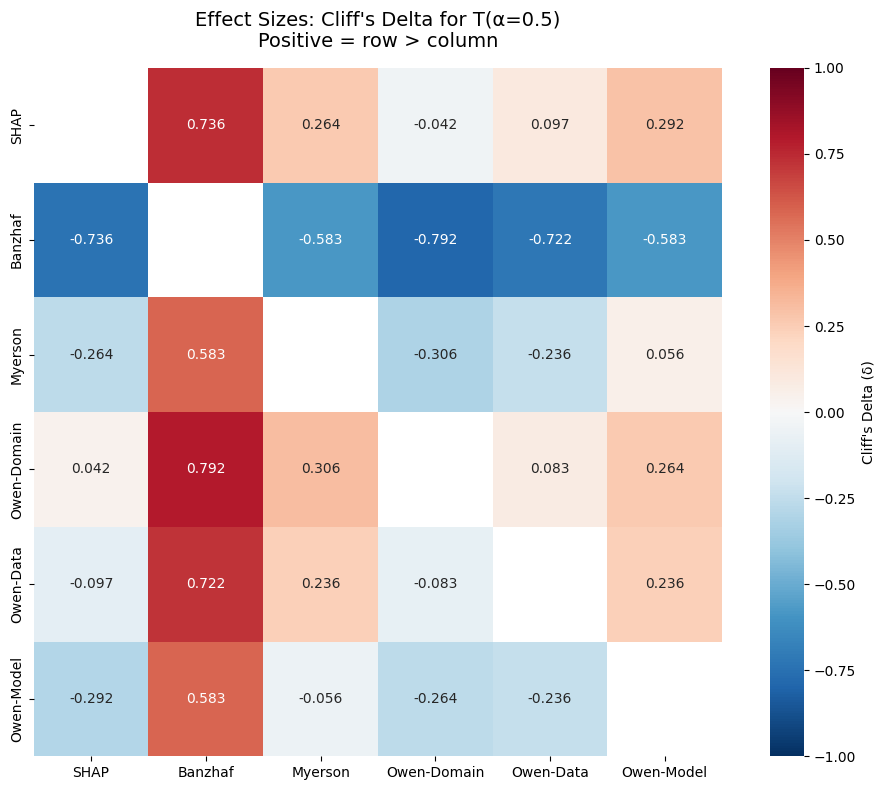

✓ Effect size heatmap saved as: german_effect_sizes_heatmap.png

STATISTICAL ANALYSIS COMPLETE


In [2]:
# ============================================================
# COMPREHENSIVE STATISTICAL ANALYSIS - GERMAN DATASET
# ============================================================

print("\n" + "="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS - GERMAN DATASET")
print("="*80)

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the unified results
try:
    metrics = pd.read_csv('german_unified_results_fixed.csv')
    print("✓ Unified results loaded successfully")
    print(f"Shape: {metrics.shape}, Methods: {metrics['Method'].nunique()}")
    print(f"Methods present: {metrics['Method'].unique()}")
except FileNotFoundError:
    print("⚠ File not found, using in-memory metrics if available")
    # If metrics is already in memory from previous run
    if 'metrics' not in globals():
        raise ValueError("Please run the unified experiment first or ensure 'metrics' exists")

# Ensure we have the required columns
required_cols = ['Method', 'AUC', 'I', 'T(α=0.5)', 'CV', 'Stability', 'Kuncheva', 'Cosine']
if all(col in metrics.columns for col in required_cols):

    # ============================================================
    # 1. LEVENE'S TEST (Equal Variances)
    # ============================================================
    print("\n" + "="*80)
    print("1. LEVENE'S TEST (Equal Variances)")
    print("="*80)

    methods = metrics['Method'].unique()

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        print(f"\n{metric}:")
        groups = []
        group_labels = []

        for method in methods:
            data = metrics[metrics['Method'] == method][metric].values
            if len(data) >= 3:
                groups.append(data)
                group_labels.append(method)

        if len(groups) >= 2:
            try:
                stat, p_value = stats.levene(*groups)
                result = "Equal variances ✓" if p_value > 0.05 else "Unequal variances ✗"
                print(f"  W = {stat:.4f}, p = {p_value:.4f} → {result}")
                print(f"  Methods compared: {group_labels}")
            except Exception as e:
                print(f"  Could not compute: {e}")
        else:
            print(f"  Insufficient data for Levene's test")

    # ============================================================
    # 2. SHAPIRO-WILK NORMALITY TESTS
    # ============================================================
    print("\n" + "="*80)
    print("2. SHAPIRO-WILK NORMALITY TESTS")
    print("="*80)

    for metric in ['AUC', 'I', 'T(α=0.5)', 'Stability', 'Kuncheva', 'Cosine']:
        if metric in metrics.columns:
            print(f"\n{metric}:")
            for method in sorted(methods):
                data = metrics[metrics['Method'] == method][metric].values
                if len(data) >= 3 and len(data) <= 5000:
                    try:
                        stat, p_value = stats.shapiro(data)
                        normal = "Normal ✓" if p_value > 0.05 else "Non-normal ✗"
                        print(f"  {method:15}: W = {stat:.4f}, p = {p_value:.4f} → {normal}")
                    except:
                        print(f"  {method:15}: Could not compute")

    # ============================================================
    # 3. SPEARMAN CORRELATION (AUC vs I)
    # ============================================================
    print("\n" + "="*80)
    print("3. SPEARMAN CORRELATION (AUC vs Interpretability)")
    print("="*80)

    # Overall correlation
    print("\nOverall Correlation:")
    rho, p_value = stats.spearmanr(metrics['AUC'], metrics['I'])
    sig = "✓" if p_value < 0.05 else "✗"
    direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
    strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
    print(f"  ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

    # By method
    print("\nCorrelation by Method:")
    for method in sorted(methods):
        subset = metrics[metrics['Method'] == method]
        if len(subset) >= 3:
            rho, p_value = stats.spearmanr(subset['AUC'], subset['I'])
            sig = "✓" if p_value < 0.05 else "✗"
            direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
            strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
            print(f"  {method:15}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

    # ============================================================
    # 4. CLIFF'S DELTA EFFECT SIZES
    # ============================================================
    print("\n" + "="*80)
    print("4. CLIFF'S DELTA EFFECT SIZES")
    print("="*80)

    def cliffs_delta(x, y):
        """Calculate Cliff's delta effect size"""
        nx, ny = len(x), len(y)
        greater = sum(1 for i in x for j in y if i > j)
        less = sum(1 for i in x for j in y if i < j)
        return (greater - less) / (nx * ny)

    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147: return "negligible"
        elif abs_delta < 0.33: return "small"
        elif abs_delta < 0.474: return "medium"
        else: return "large"

    # Key pairwise comparisons
    key_pairs = [
        ('SHAP', 'Banzhaf'),
        ('SHAP', 'Myerson'),
        ('SHAP', 'Owen-Domain'),
        ('SHAP', 'Owen-Data'),
        ('SHAP', 'Owen-Model'),
        ('Owen-Domain', 'Owen-Data'),
        ('Owen-Domain', 'Owen-Model'),
        ('Owen-Data', 'Owen-Model'),
        ('Banzhaf', 'Myerson')
    ]

    print("\nTrade-off (T) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
            data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")

    print("\nInterpretability (I) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = metrics[metrics['Method'] == method1]['I'].values
            data2 = metrics[metrics['Method'] == method2]['I'].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")

    # ============================================================
    # 5. SUMMARY STATISTICS
    # ============================================================
    print("\n" + "="*80)
    print("5. SUMMARY STATISTICS BY METHOD")
    print("="*80)

    summary = metrics.groupby('Method').agg({
        'AUC': ['mean', 'std', 'count'],
        'I': ['mean', 'std'],
        'Stability': ['mean', 'std'],
        'Kuncheva': ['mean', 'std'],
        'Cosine': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std', 'min', 'max']
    }).round(4)

    print("\nPerformance Summary (mean ± standard deviation):")
    print(summary.to_string())

    # Best and worst methods
    print("\n" + "="*80)
    print("BEST AND WORST PERFORMING METHODS")
    print("="*80)

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        best_method = metrics.groupby('Method')[metric].mean().idxmax()
        best_value = metrics.groupby('Method')[metric].mean().max()
        worst_method = metrics.groupby('Method')[metric].mean().idxmin()
        worst_value = metrics.groupby('Method')[metric].mean().min()

        print(f"\n{metric}:")
        print(f"  Best: {best_method} = {best_value:.4f}")
        print(f"  Worst: {worst_method} = {worst_value:.4f}")
        print(f"  Difference: {best_value - worst_value:.4f}")

    # ============================================================
    # 6. VISUALIZATION: EFFECT SIZE HEATMAP
    # ============================================================
    print("\n" + "="*80)
    print("6. VISUALIZING EFFECT SIZES...")
    print("="*80)

    # Create effect size matrix for T(α=0.5)
    effect_matrix = pd.DataFrame(index=methods, columns=methods)

    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i != j:
                data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
                data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

                if len(data1) > 1 and len(data2) > 1:
                    delta = cliffs_delta(data1, data2)
                    effect_matrix.loc[method1, method2] = delta
                else:
                    effect_matrix.loc[method1, method2] = np.nan

    # Convert to float and plot
    effect_matrix = effect_matrix.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(effect_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, square=True,
                cbar_kws={'label': "Cliff's Delta (δ)"})
    plt.title("Effect Sizes: Cliff's Delta for T(α=0.5)\nPositive = row > column",
              fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig('german_effect_sizes_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Effect size heatmap saved as: german_effect_sizes_heatmap.png")

else:
    print("⚠ Required columns not found in metrics dataframe")

print("\n" + "="*80)
print("STATISTICAL ANALYSIS COMPLETE")
print("="*80)

In [3]:
import numpy as np
import pandas as pd

# Extract cosine scores per method
cosine_scores = metrics.groupby("Method")["Cosine"].mean()

# 1. Difference-based similarity
methods = cosine_scores.index
sim_matrix = pd.DataFrame(index=methods, columns=methods)

for m1 in methods:
    for m2 in methods:
        sim_matrix.loc[m1, m2] = 1 - abs(cosine_scores[m1] - cosine_scores[m2])

sim_matrix = sim_matrix.astype(float)
print("Cosine Similarity Matrix (difference-based):")
print(sim_matrix.round(3))


Cosine Similarity Matrix (difference-based):
Method       Banzhaf  Myerson  Owen-Data  Owen-Domain  Owen-Model   SHAP
Method                                                                  
Banzhaf        1.000    0.579      0.422        0.447       0.513  0.403
Myerson        0.579    1.000      0.842        0.868       0.934  0.823
Owen-Data      0.422    0.842      1.000        0.975       0.908  0.981
Owen-Domain    0.447    0.868      0.975        1.000       0.934  0.956
Owen-Model     0.513    0.934      0.908        0.934       1.000  0.889
SHAP           0.403    0.823      0.981        0.956       0.889  1.000


In [4]:
corr_matrix = metrics.pivot_table(
    values="Cosine",
    index=["Model","Sampler"],
    columns="Method"
).corr(method="spearman")

print("Cosine Similarity Matrix (Spearman correlation):")
print(corr_matrix.round(3))


Cosine Similarity Matrix (Spearman correlation):
Method       Banzhaf  Myerson  Owen-Data  Owen-Domain  Owen-Model   SHAP
Method                                                                  
Banzhaf        1.000    0.583     -0.167        0.217      -0.067  0.600
Myerson        0.583    1.000     -0.450        0.817       0.517  0.483
Owen-Data     -0.167   -0.450      1.000       -0.600       0.067 -0.433
Owen-Domain    0.217    0.817     -0.600        1.000       0.350  0.283
Owen-Model    -0.067    0.517      0.067        0.350       1.000  0.033
SHAP           0.600    0.483     -0.433        0.283       0.033  1.000


In [6]:
# ============================================================
# GERMAN DATASET - FEATURE & GROUPING ANALYSIS
# ============================================================

print("\n" + "="*80)
print("GERMAN CREDIT DATASET - FEATURE & GROUPING ANALYSIS")
print("="*80)

import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Get feature names
fnames = preprocessor.get_feature_names_out()
print(f"\nTotal processed features: {len(fnames)}")
print(f"Original features: {len(cat_cols)} categorical + {len(num_cols)} numeric = {len(cat_cols) + len(num_cols)}")

# ============================================================
# 1. PRINT ALL FEATURES WITH INDICES
# ============================================================
print("\n" + "="*80)
print("1. ALL PROCESSED FEATURES WITH INDICES")
print("="*80)

# Group features by original column
feature_groups = {}
for i, fname in enumerate(fnames):
    # Find which original column this belongs to
    found = False
    for cat_col in cat_cols:
        if cat_col in fname:
            if cat_col not in feature_groups:
                feature_groups[cat_col] = []
            feature_groups[cat_col].append((i, fname))
            found = True
            break

    if not found:
        for num_col in num_cols:
            if num_col == fname.replace('num__', ''):
                if num_col not in feature_groups:
                    feature_groups[num_col] = []
                feature_groups[num_col].append((i, fname))
                break

# Print features by original column
print("\nFEATURES BY ORIGINAL COLUMN:")
print("-" * 70)

for col in sorted(feature_groups.keys()):
    features = feature_groups[col]
    print(f"\n{col} ({len(features)} encoded features):")
    for idx, fname in sorted(features):
        clean_name = fname.replace('cat__', '').replace('num__', '')
        print(f"  [{idx:3d}] {clean_name}")

# ============================================================
# 2. DOMAIN GROUPS ANALYSIS
# ============================================================
print("\n\n" + "="*80)
print("2. DOMAIN GROUPS (EXPERT-DEFINED)")
print("="*80)

def build_domain_groups_german_detailed(fnames):
    """Build domain groups with detailed feature listing"""
    groups = {
        "1. CreditHistory": [],
        "2. FinancialStatus": [],
        "3. PersonalInfo": [],
        "4. LoanDetails": [],
        "5. Employment": []
    }

    feature_details = {}

    for i, name in enumerate(fnames):
        lname = name.lower()
        clean_name = name.replace('cat__', '').replace('num__', '')

        # Credit history related
        if "checking_status" in lname:
            groups["1. CreditHistory"].append(i)
            feature_details[i] = (clean_name, "Checking account status")
        elif "savings_status" in lname:
            groups["1. CreditHistory"].append(i)
            feature_details[i] = (clean_name, "Savings account/bonds")
        elif "credit_history" in lname:
            groups["1. CreditHistory"].append(i)
            feature_details[i] = (clean_name, "Credit history")

        # Financial status
        elif "credit_amount" in lname:
            groups["2. FinancialStatus"].append(i)
            feature_details[i] = (clean_name, "Credit amount")
        elif "property_magnitude" in lname:
            groups["2. FinancialStatus"].append(i)
            feature_details[i] = (clean_name, "Property magnitude")
        elif "housing" in lname:
            groups["2. FinancialStatus"].append(i)
            feature_details[i] = (clean_name, "Housing status")

        # Personal info
        elif "age" in lname:
            groups["3. PersonalInfo"].append(i)
            feature_details[i] = (clean_name, "Age")
        elif "personal_status" in lname:
            groups["3. PersonalInfo"].append(i)
            feature_details[i] = (clean_name, "Personal status & sex")
        elif "num_dependents" in lname:
            groups["3. PersonalInfo"].append(i)
            feature_details[i] = (clean_name, "Number of dependents")
        elif "residence_since" in lname:
            groups["3. PersonalInfo"].append(i)
            feature_details[i] = (clean_name, "Years at residence")

        # Loan details
        elif "duration" in lname:
            groups["4. LoanDetails"].append(i)
            feature_details[i] = (clean_name, "Loan duration (months)")
        elif "purpose" in lname:
            groups["4. LoanDetails"].append(i)
            feature_details[i] = (clean_name, "Loan purpose")
        elif "installment_commitment" in lname:
            groups["4. LoanDetails"].append(i)
            feature_details[i] = (clean_name, "Installment rate (%)")

        # Employment
        elif "employment" in lname:
            groups["5. Employment"].append(i)
            feature_details[i] = (clean_name, "Employment length")
        elif "job" in lname:
            groups["5. Employment"].append(i)
            feature_details[i] = (clean_name, "Job type")

        # Other features not in main groups
        elif "other_parties" in lname:
            groups["1. CreditHistory"].append(i)  # Put with credit history
            feature_details[i] = (clean_name, "Other debtors/guarantors")
        elif "other_payment_plans" in lname:
            groups["4. LoanDetails"].append(i)  # Put with loan details
            feature_details[i] = (clean_name, "Other payment plans")
        elif "existing_credits" in lname:
            groups["4. LoanDetails"].append(i)  # Put with loan details
            feature_details[i] = (clean_name, "Number of existing credits")
        elif "own_telephone" in lname:
            groups["3. PersonalInfo"].append(i)  # Put with personal info
            feature_details[i] = (clean_name, "Telephone")
        elif "foreign_worker" in lname:
            groups["5. Employment"].append(i)  # Put with employment
            feature_details[i] = (clean_name, "Foreign worker")

    return groups, feature_details

# Build and print domain groups
dom_groups, feature_details = build_domain_groups_german_detailed(fnames)

total_features_in_groups = sum(len(feats) for feats in dom_groups.values())
print(f"\nDomain groups cover {total_features_in_groups} out of {len(fnames)} features ({total_features_in_groups/len(fnames)*100:.1f}%)")

for group_name in sorted(dom_groups.keys()):
    features = sorted(dom_groups[group_name])
    print(f"\n{group_name} ({len(features)} features):")
    print("-" * 60)

    for idx in features:
        if idx in feature_details:
            fname, description = feature_details[idx]
            print(f"  [{idx:3d}] {fname:40} | {description}")
        else:
            clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
            print(f"  [{idx:3d}] {clean_name}")

# Features not assigned to any group
all_assigned = set()
for feats in dom_groups.values():
    all_assigned.update(feats)

unassigned = [i for i in range(len(fnames)) if i not in all_assigned]
if unassigned:
    print(f"\n⚠ {len(unassigned)} features not assigned to any domain group:")
    for idx in unassigned:
        clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
        print(f"  [{idx:3d}] {clean_name}")

# ============================================================
# 3. DATA-DRIVEN GROUPS (Correlation Clustering)
# ============================================================
print("\n\n" + "="*80)
print("3. DATA-DRIVEN GROUPS (Correlation Clustering)")
print("="*80)

# Use a sample for clustering - FIXED: removed random_state parameter
np.random.seed(42)  # Set seed globally
sample_size = min(500, len(X))
sample_idx = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[sample_idx]
X_proc_sample = preprocessor.transform(X_sample)

data_groups, corr_matrix = build_data_groups(X_proc_sample, n_groups=6)

print(f"\nData-driven clustering created {len(data_groups)} groups")
print(f"Correlation matrix shape: {corr_matrix.shape}")

# Print data groups
for i, (group_name, features) in enumerate(sorted(data_groups.items())):
    features = sorted(features)
    print(f"\n{group_name} ({len(features)} features):")
    print("-" * 40)

    # Show features and their original columns
    for idx in features[:15]:  # Show first 15 features
        if idx < len(fnames):
            clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
            # Find original column
            orig_col = "Unknown"
            for col in cat_cols + num_cols:
                if col in clean_name or clean_name == col:
                    orig_col = col
                    break
            print(f"  [{idx:3d}] {clean_name:35} | Orig: {orig_col}")

    if len(features) > 15:
        print(f"  ... and {len(features)-15} more features")

# ============================================================
# 4. MODEL-DRIVEN GROUPS (SHAP Clustering)
# ============================================================
print("\n\n" + "="*80)
print("4. MODEL-DRIVEN GROUPS (SHAP Clustering)")
print("="*80)

print("Training a sample model for SHAP clustering...")
from sklearn.ensemble import RandomForestClassifier

# Train on a sample - FIXED: removed random_state parameter
np.random.seed(42)
train_size = min(300, len(X))
train_idx = np.random.choice(len(X), train_size, replace=False)
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

simple_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
pipe_simple = ImbPipeline([('prep', preprocessor), ('clf', simple_model)])
pipe_simple.fit(X_train, y_train)

# Get SHAP values - FIXED: removed random_state parameter
np.random.seed(42)
bg_size = min(100, len(X_train))
bg_sample = X_train.sample(n=bg_size)
shap_vals = get_shap_reliable(pipe_simple, bg_sample)

model_groups, shap_corr = build_model_groups(shap_vals, n_groups=6)

print(f"\nSHAP-based clustering created {len(model_groups)} groups")
print(f"SHAP correlation matrix shape: {shap_corr.shape}")

# Print model groups
for i, (group_name, features) in enumerate(sorted(model_groups.items())):
    features = sorted(features)
    print(f"\n{group_name} ({len(features)} features):")
    print("-" * 40)

    # Show features and their original columns
    for idx in features[:15]:  # Show first 15 features
        if idx < len(fnames):
            clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
            # Find original column
            orig_col = "Unknown"
            for col in cat_cols + num_cols:
                if col in clean_name or clean_name == col:
                    orig_col = col
                    break

            # Get mean absolute SHAP value for this feature
            if shap_vals is not None and idx < shap_vals.shape[1]:
                shap_importance = np.mean(np.abs(shap_vals[:, idx]))
                print(f"  [{idx:3d}] {clean_name:30} | Orig: {orig_col:15} | SHAP: {shap_importance:.4f}")
            else:
                print(f"  [{idx:3d}] {clean_name:30} | Orig: {orig_col}")

    if len(features) > 15:
        print(f"  ... and {len(features)-15} more features")

# ============================================================
# 5. COMPARISON SUMMARY
# ============================================================
print("\n\n" + "="*80)
print("5. GROUPING STRATEGY COMPARISON SUMMARY")
print("="*80)

from collections import Counter

all_groupings = {
    "Domain": dom_groups,
    "Data": data_groups,
    "Model": model_groups
}

# Create comparison table
summary_data = []

for strategy_name, groups in all_groupings.items():
    group_sizes = [len(feats) for feats in groups.values()]

    # Get all features in this strategy
    all_features = set()
    for feats in groups.values():
        all_features.update(feats)

    # Count feature types
    cat_feats = 0
    num_feats = 0
    for idx in all_features:
        if idx < len(fnames):
            fname = fnames[idx]
            if fname.startswith('cat__'):
                cat_feats += 1
            elif fname.startswith('num__'):
                num_feats += 1

    summary_data.append({
        'Strategy': strategy_name,
        'Num_Groups': len(groups),
        'Total_Features': len(all_features),
        'Coverage': f"{len(all_features)}/{len(fnames)} ({len(all_features)/len(fnames)*100:.1f}%)",
        'Avg_Group_Size': f"{np.mean(group_sizes):.1f}",
        'Std_Group_Size': f"{np.std(group_sizes):.1f}",
        'Min_Group_Size': min(group_sizes),
        'Max_Group_Size': max(group_sizes),
        'Cat_Features': cat_feats,
        'Num_Features': num_feats
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# ============================================================
# 6. ORIGINAL DATA STATISTICS
# ============================================================
print("\n\n" + "="*80)
print("6. ORIGINAL DATASET STATISTICS")
print("="*80)

print("\nCategorical Features:")
print("-" * 40)
for col in cat_cols:
    unique_vals = X[col].unique()
    print(f"{col:25} : {len(unique_vals):2d} unique values → {len(unique_vals)-1} encoded features")
    if len(unique_vals) <= 10:
        print(f"  Values: {', '.join(map(str, unique_vals))}")

print("\nNumerical Features:")
print("-" * 40)
for col in num_cols:
    stats = X[col].describe()
    print(f"{col:25} : mean={stats['mean']:.1f}, std={stats['std']:.1f}, min={stats['min']:.0f}, max={stats['max']:.0f}")

# ============================================================
# 7. FEATURE IMPORTANCE PREVIEW
# ============================================================
print("\n\n" + "="*80)
print("7. FEATURE IMPORTANCE PREVIEW (from sample model)")
print("="*80)

if shap_vals is not None:
    # Calculate mean absolute SHAP values
    shap_importance = np.mean(np.abs(shap_vals), axis=0)

    # Get top 20 most important features
    top_indices = np.argsort(shap_importance)[-20:][::-1]

    print("\nTop 20 Most Important Features (by mean |SHAP|):")
    print("-" * 70)
    print(f"{'Index':^6} | {'Feature':40} | {'Original Column':20} | {'Importance':>10}")
    print("-" * 70)

    for idx in top_indices:
        if idx < len(fnames):
            clean_name = fnames[idx].replace('cat__', '').replace('num__', '')
            # Find original column
            orig_col = "Unknown"
            for col in cat_cols + num_cols:
                if col in clean_name or clean_name == col:
                    orig_col = col
                    break

            importance = shap_importance[idx]
            print(f"{idx:6d} | {clean_name:40} | {orig_col:20} | {importance:10.6f}")

print("\n" + "="*80)
print("FEATURE & GROUPING ANALYSIS COMPLETE")
print("="*80)

# Save groupings to file
import json

# Prepare groupings for JSON export
groupings_data = {
    'feature_names': fnames.tolist(),
    'domain_groups': {k: sorted(v) for k, v in dom_groups.items()},
    'data_groups': {k: sorted(v) for k, v in data_groups.items()},
    'model_groups': {k: sorted(v) for k, v in model_groups.items()},
    'original_categorical': cat_cols,
    'original_numerical': num_cols,
    'feature_details': {str(k): v for k, v in feature_details.items()}
}

with open('german_feature_groupings.json', 'w') as f:
    json.dump(groupings_data, f, indent=2)

print("\n✓ Feature groupings saved to: german_feature_groupings.json")

# Also save as CSV for easy viewing
import csv

with open('german_feature_assignments.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Feature_Index', 'Feature_Name', 'Original_Column', 'Domain_Group', 'Data_Group', 'Model_Group'])

    for i in range(len(fnames)):
        # Find domain group
        domain_group = 'None'
        for group_name, features in dom_groups.items():
            if i in features:
                domain_group = group_name.replace('1. ', '').replace('2. ', '').replace('3. ', '').replace('4. ', '').replace('5. ', '')
                break

        # Find data group
        data_group = 'None'
        for group_name, features in data_groups.items():
            if i in features:
                data_group = group_name
                break

        # Find model group
        model_group = 'None'
        for group_name, features in model_groups.items():
            if i in features:
                model_group = group_name
                break

        # Find original column
        orig_col = 'Unknown'
        for col in cat_cols + num_cols:
            if col in fnames[i] or fnames[i].replace('cat__', '').replace('num__', '') == col:
                orig_col = col
                break

        writer.writerow([i, fnames[i], orig_col, domain_group, data_group, model_group])

print("✓ Feature assignments saved to: german_feature_assignments.csv")


GERMAN CREDIT DATASET - FEATURE & GROUPING ANALYSIS

Total processed features: 48
Original features: 13 categorical + 7 numeric = 20

1. ALL PROCESSED FEATURES WITH INDICES

FEATURES BY ORIGINAL COLUMN:
----------------------------------------------------------------------

age (1 encoded features):
  [ 45] age

checking_status (3 encoded features):
  [  0] checking_status_A12
  [  1] checking_status_A13
  [  2] checking_status_A14

credit_amount (1 encoded features):
  [ 42] credit_amount

credit_history (4 encoded features):
  [  3] credit_history_A31
  [  4] credit_history_A32
  [  5] credit_history_A33
  [  6] credit_history_A34

duration (1 encoded features):
  [ 41] duration

employment (4 encoded features):
  [ 20] employment_A72
  [ 21] employment_A73
  [ 22] employment_A74
  [ 23] employment_A75

existing_credits (1 encoded features):
  [ 46] existing_credits

foreign_worker (1 encoded features):
  [ 40] foreign_worker_A202

housing (2 encoded features):
  [ 34] housing_A152
